# Import Library

In [1]:
import numpy as np
import math
import natsort
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

# Data Loder

In [2]:
dir_path = os.getenv("HOME") + '/Cloud_data'

In [84]:
Atrous_unet_model_path = dir_path + '/cloud_model/seg_atrous_unet_model_sliding800_class4_epoch20_gaussian5.h5'

In [85]:
Atrous_unet_model = tf.keras.models.load_model(Atrous_unet_model_path)

In [86]:
def sortlist(filelist):
    filelist = natsort.natsorted(filelist)
    return filelist

In [87]:
dir_path = os.getenv("HOME") + '/Cloud_data'

validation_dir_path = dir_path + '/cloud_validation/'

validation_labeling_file_path = os.path.join(validation_dir_path,'validate_clouds_labeling/')

validation_label_file_list = glob(os.path.join(validation_labeling_file_path,"*png"))
validation_label_file_list = sortlist(validation_label_file_list)

# Test 

---

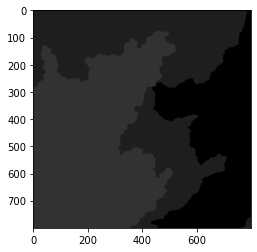

In [5]:
img = cv2.imread('/home/mjy0992/Cloud_data/cloud_validation/patch_labeling800/img1_2.png')
plt.imshow(img)

<class 'numpy.ndarray'>
(800, 800, 3)
[ 0 30 50]


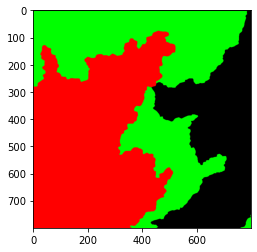

In [6]:
# img[:600,:600]
print(type(img))
print(img.shape)
print(np.unique(img))
# print(img)
label_seg = np.zeros((img.shape),dtype=np.uint8)
r = np.array([50, 50, 50])
g = np.array([30, 30, 30])
y = np.array([10, 10, 10])

label_seg[(img==r).all(axis=2)] = 255,0,0
label_seg[(img==g).all(axis=2)] = 0,255,0
label_seg[(img==y).all(axis=2)] = 255,255,0

plt.imshow(label_seg); plt.show()

In [7]:
asd = np.zeros((3,10,10))
a = np.full((3,10,10),0)
a[0,4:7,4:7] = 50
a[1,:3,:3] = 30
a[2,7:,7:] = 10
# print(a)
# print((a[0,:,:] == 50).astype(np.uint8)*1)
# print((a[1,:,:] == 30).astype(np.uint8)*1)
# print((a[2,:,:] == 10).astype(np.uint8)*1)
asd[0,:,:] = (a[0,:,:] == 50).astype(np.uint8)*255
asd[1,:,:] = (a[1,:,:] == 30).astype(np.uint8)*255
asd[2,:,:] = (a[2,:,:] == 10).astype(np.uint8)*255

asd
def test_label(img):
    bl = np.array([0,0,0])
    r = np.array([1,1,1])
    g = np.array([2,2,2])
    y = np.array([3,3,3])
    
    img_rgb = np.zeros([800,800,3],dtype=np.uint8)
    img_rgb[:,:,0] = img
    img_rgb[:,:,1] = img
    img_rgb[:,:,2] = img
    
    img_rgb[(img_rgb==bl).all(axis=2)] = 0,0,0     #  Ground      : 0
    img_rgb[(img_rgb==r).all(axis=2)] = 255,0,0    # Thick Cloud  : 1
    img_rgb[(img_rgb==g).all(axis=2)] = 0,255,0    # Thin Cloud   : 2
    img_rgb[(img_rgb==y).all(axis=2)] = 255,255,0  # Cloud shadow : 3
    

---

In [88]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    if float(np.sum(union)) == 0:
        return 0
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    
    return iou_score

In [89]:
def test_label(img,img_col,img_row):
    y = np.array([0,0,255])
    
    img_rgb = np.zeros([img_col,img_row,3],dtype=np.uint8)
    
    img1 = (img==0).astype(np.uint8)*255
    img2 = (img==1).astype(np.uint8)*255
    img3 = (img==2).astype(np.uint8)*255
    
    img_rgb[:,:,0] = img1
    img_rgb[:,:,1] = img2
    img_rgb[:,:,2] = img3
    
    img_rgb[(img_rgb==y).all(axis=2)] = 255,255,0  # Cloud shadow : 3
    return img_rgb

def pred_label(img,img_col,img_row):
    pred_img = np.zeros([img_col,img_row],dtype=np.uint8)
    img[img==0]=1
    img[img==1]=1
    img[img==2]=1
    img[img==3]=0

    pred_img = img
    return pred_img
    
def get_output(model, image_path, output_path, label_path):
    
    origin_img = cv2.imread(image_path)
    output = model(np.expand_dims(origin_img/255, axis=0)) # 1,800,800,3
    output = np.argmax(output, axis=-1) # 1,800,800
    output = output[0].astype(np.uint8)# 800x800
    prediction = output
    
    if label_path:
        label_img = cv2.imread(label_path,0)
        label_img = label_img[:,25:-25]
        label_img[label_img==50] = 1
        label_img[label_img==30] = 1
        label_img[label_img==10] = 1
        label_img[label_img==0] = 0
        
        target = label_img
        return output, prediction, target
    else:
        return output, prediction, _

In [68]:
validation_label_file_list[0]

'/home/mjy0992/Cloud_data/cloud_validation/validate_clouds_labeling/CLD00006_MS4_K3A_NIA0006_label.png'

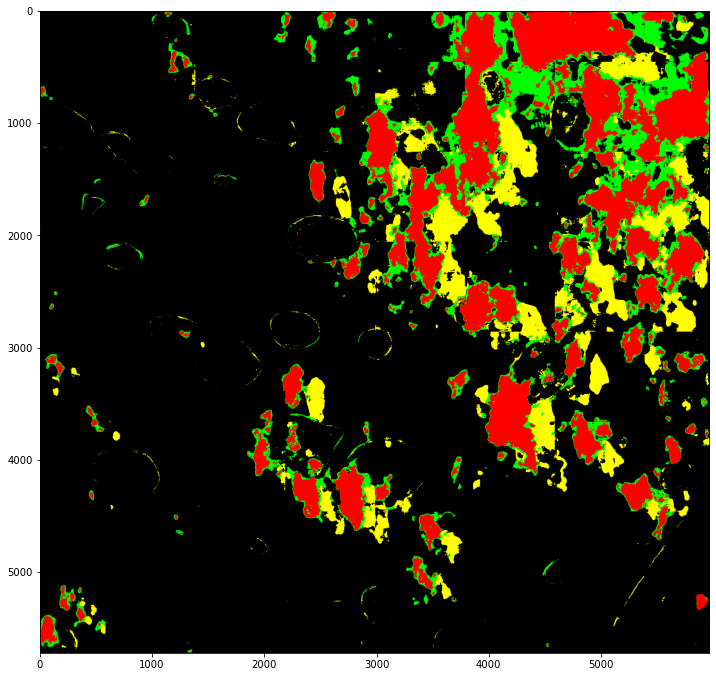

0.6488725199672621


In [94]:
img_num = 15
seg_result_list = []
iou_avg = 0
test_dir_path = dir_path + '/cloud_validation'
none_0 = 64

for j in range(64):
    i = img_num
    j = j+1
    output, prediction, target = get_output(
        Atrous_unet_model,
        image_path = test_dir_path + f'/zero_patch_img/img{i}_{j}.png',
        output_path = test_dir_path + f'/output_test/img{i}_{j}.png',
        label_path = validation_label_file_list[i-1]
     )
    
    seg_result_list.append(output)

combine_img2 = np.empty((1,6400))
for i in range(8):
    combine_img = np.empty((800,1))
    combine_img = seg_result_list[i*8]

    for k in range(1,8):
        combine_img = np.hstack((combine_img, seg_result_list[i*8+k]))
    combine_img2 = np.vstack((combine_img2, combine_img))

row_empty_size = (combine_img2.shape[1] - target.shape[1]) // 2
col_empty_size = (combine_img2.shape[0] - target.shape[0]) // 2
combine_output= combine_img2[col_empty_size:col_empty_size*-1-1,row_empty_size:row_empty_size*-1-1]

output_image = test_label(combine_output,combine_output.shape[0],combine_output.shape[1])
pred_image = pred_label(combine_output,combine_output.shape[0],combine_output.shape[1])

plt.figure(figsize = (12,12))
plt.imshow(output_image); plt.show()

print(calculate_iou_score(target, pred_image))
